In [ ]:
# 1. COLLEGARE GOOGLE DRIVE
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Questo comando ti chiederà l'autorizzazione per accedere al Drive
drive.mount('/content/drive')

# --- 1. CARICAMENTO DATI ---
# Assicurati che il percorso sia quello dove hai salvato il file creato prima
FILE_PATH = "/content/drive/MyDrive/train/dataset_completo_train.csv"

print("Caricamento dataset...")
df = pd.read_csv(FILE_PATH)

Mounted at /content/drive
Caricamento dataset...


Features utilizzate: 56 colonne
Esempi totali: 177

Avvio Cross-Validation (5 Folds)...

--- RISULTATI CROSS-VALIDATION TASK 1 ---
Accuratezza Media: 100.00%
Deviazione Standard: (+/- 0.00%)
Punteggi singoli fold: [1. 1. 1. 1. 1.]


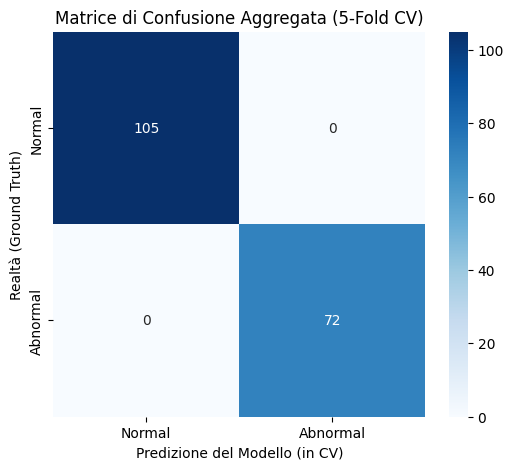


Addestramento finale del modello sull'intero dataset...

Top 10 Feature più importanti:
1. P3_Start_Slope (0.1657)
2. P3_Start_Std (0.1551)
3. P3_Start_Mean (0.1028)
4. P6_Start_Std (0.0864)
5. P6_Start_Mean (0.0589)
6. P4_Start_Slope (0.0533)
7. P4_Start_Std (0.0492)
8. P1_Start_Std (0.0479)
9. P2_Start_Std (0.0461)
10. P5_Global_Min (0.0329)


In [ ]:
# =============================================================================
# TASK 1: TRAINING & VALIDAZIONE (CROSS-VALIDATION)
# 1. Caricamento dataset di training e selezione feature statistiche.
# 2. Validazione Robusta (Stratified K-Fold) per stimare l'accuratezza media.
# 3. Addestramento finale su tutto il dataset per l'uso successivo.
# =============================================================================

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- 2. PREPARAZIONE FEATURES (X) E TARGET (y) ---
metadata_cols = ['Case', 'Spacecraft', 'Condition',
                 'SV1', 'SV2', 'SV3', 'SV4',
                 'BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7', 'BV1']
target_cols = ['Target_Task1', 'Target_Task2', 'Target_Task3', 'Target_Task4', 'Target_Task5']

# X: Features Statistiche
drop_cols = metadata_cols + target_cols
X = df.drop(columns=drop_cols, errors='ignore')

# y: Target Task 1 (0=Normal, 1=Abnormal)
y_task1 = df['Target_Task1']

print(f"Features utilizzate: {X.shape[1]} colonne")
print(f"Esempi totali: {len(X)}")

# --- 3. CONFIGURAZIONE CROSS-VALIDATION (5-Fold Stratified) ---
# Stratified assicura che la percentuale di guasti sia la stessa in ogni fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)

print("\nAvvio Cross-Validation (5 Folds)...")

# --- 4. ESECUZIONE VALIDAZIONE ---
# Calcola l'accuratezza per ogni fold
scores = cross_val_score(clf, X, y_task1, cv=cv, scoring='accuracy')

print(f"\n--- RISULTATI CROSS-VALIDATION TASK 1 ---")
print(f"Accuratezza Media: {scores.mean()*100:.2f}%")
print(f"Deviazione Standard: (+/- {scores.std()*100:.2f}%)")
print(f"Punteggi singoli fold: {scores}")

# Genera predizioni 'pulite' per la matrice di confusione aggregata
# (Simula come si comporta il modello su dati non visti per ogni fold)
y_pred_cv = cross_val_predict(clf, X, y_task1, cv=cv)

# --- 5. VISUALIZZAZIONE MATRICE DI CONFUSIONE AGGREGATA ---
cm = confusion_matrix(y_task1, y_pred_cv)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Abnormal'],
            yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predizione del Modello (in CV)')
plt.ylabel('Realtà (Ground Truth)')
plt.title('Matrice di Confusione Aggregata (5-Fold CV)')
plt.show()

# --- 6. ADDESTRAMENTO FINALE (Full Retrain) ---
# Ora che sappiamo che il modello funziona, lo addestriamo su TUTTI i dati
# per usarlo nella prossima cella sul Test Set reale.
print("\nAddestramento finale del modello sull'intero dataset...")
clf.fit(X, y_task1)

# --- BONUS: FEATURE IMPORTANCE (Dal modello finale) ---
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nTop 10 Feature più importanti:")
for f in range(10):
    print(f"{f+1}. {X.columns[indices[f]]} ({importances[indices[f]]:.4f})")

In [ ]:
# =============================================================================
# TASK 1: PREDIZIONE SUL TEST SET
# 1. Applicazione del modello su nuovi dati.
# 2. Calcolo della confidenza per analizzare la robustezza delle predizioni.
# =============================================================================


# --- 1. CARICAMENTO DEL TEST SET ---
TEST_PATH = "/content/drive/MyDrive/test/dataset_completo_test.csv"

print("Caricamento test set...")
df_test = pd.read_csv(TEST_PATH)

# Prepariamo le feature: dobbiamo usare le STESSE colonne usate per X_train
# Rimuoviamo 'Case' e 'Spacecraft' per avere solo le feature statistiche (le 56 colonne)
X_test_final = df_test.drop(columns=['Case', 'Spacecraft'], errors='ignore')

# Verifica coerenza colonne
if list(X_test_final.columns) == list(X.columns):
    print("✅ Coerenza feature verificata: il test set ha le stesse colonne del training.")
else:
    print("⚠️ Attenzione: Le colonne del test set non coincidono perfettamente con il training!")

# --- 2. PREDIZIONE TASK 1 (Normal vs Abnormal) ---
# Usiamo predict_proba per vedere quanto il modello è "sicuro"
y_test_probs = clf.predict_proba(X_test_final)
y_test_pred = clf.predict(X_test_final)

# Aggiungiamo i risultati al dataframe per analisi
df_test['Task1_Pred'] = y_test_pred
df_test['Confidence'] = np.max(y_test_probs, axis=1)

# --- 3. ANALISI DEI RISULTATI ---
print(f"\n--- ANALISI PREDIZIONI TASK 1 ---")
print(df_test['Task1_Pred'].value_counts().rename({0: 'Normal', 1: 'Abnormal'}))

# Analisi per Spacecraft (molto importante per il punteggio!) [cite: 2430]
print("\nSuddivisione per Spacecraft:")
print(pd.crosstab(df_test['Spacecraft'], df_test['Task1_Pred']).rename(columns={0: 'Normal', 1: 'Abnormal'}))

# Controllo casi a bassa confidenza (potenziali "Unknown" o errori)
low_conf = df_test[df_test['Confidence'] < 0.8]
if not low_conf.empty:
    print(f"\n⚠️ Trovati {len(low_conf)} casi con confidenza inferiore all'80%:")
    print(low_conf[['Case', 'Spacecraft', 'Task1_Pred', 'Confidence']])
else:
    print("\n✅ Tutti i casi sono stati classificati con alta confidenza (>80%).")

# --- 4. PREPARAZIONE SUBMISSION TEMPORANEA ---
submission_task1 = pd.DataFrame({
    'Id': df_test['Case'],
    'Task 1': df_test['Task1_Pred'],
    'Task 2': 0, # Lo riempiremo nel prossimo step
    'Task 3': 0,
    'Task 4': 0,
    'Task 5': 100
})

print("\nFile di submission parziale pronto per le task successive.")

Caricamento test set...
✅ Coerenza feature verificata: il test set ha le stesse colonne del training.

--- ANALISI PREDIZIONI TASK 1 ---
Task1_Pred
Abnormal    26
Normal      20
Name: count, dtype: int64

Suddivisione per Spacecraft:
Task1_Pred  Normal  Abnormal
Spacecraft                  
1               10        13
4               10        13

⚠️ Trovati 9 casi con confidenza inferiore all'80%:
    Case  Spacecraft  Task1_Pred  Confidence
6    184           1           1        0.69
14   192           1           1        0.69
21   199           1           1        0.70
22   200           1           1        0.69
27   205           4           1        0.70
29   207           4           1        0.69
33   211           4           1        0.74
40   218           4           1        0.70
44   222           4           1        0.69

File di submission parziale pronto per le task successive.


Esempi di guasto nel training: 72
Distribuzione classi: Target_Task2
Valvole    48
Bolle      24
Name: count, dtype: int64

Avvio Cross-Validation (5 Folds)...

--- RISULTATI ANALITICI TASK 2 ---
Accuratezza Media: 100.00%
Deviazione Standard: (+/- 0.00%)


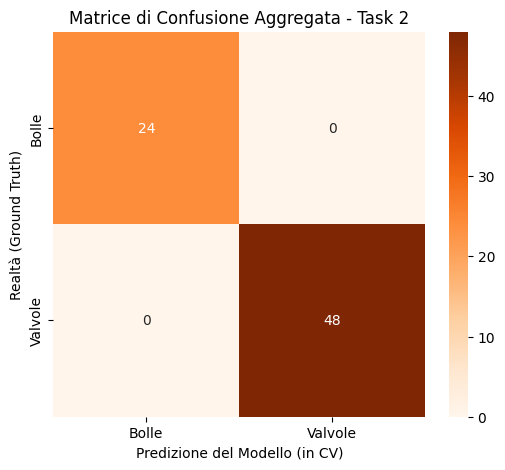


Addestramento finale del modello sui guasti...

Top 5 Feature cruciali per distinguere Bolle da Valvole:
1. P7_Start_Slope (0.1386)
2. P3_Start_Slope (0.0953)
3. P1_Start_Mean (0.0911)
4. P7_Start_Mean (0.0802)
5. P2_Global_Min (0.0711)


In [ ]:
# =============================================================================
# TASK 2: TRAINING & VALIDAZIONE (CROSS-VALIDATION)
# 1. Filtraggio: Isoliame solo i casi anomali (Target_Task1 == 1).
# 2. Validazione Robusta (Stratified K-Fold) per distinguere Bolle (2) vs Valvole (3).
# 3. Addestramento finale su tutti i casi anomali per l'uso successivo.
# =============================================================================

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- 1. FILTRAGGIO DATI PER TASK 2 ---
# Prendiamo solo i casi che sono guasti (Target_Task1 == 1)
df_anomaly = df[df['Target_Task1'] == 1].copy()

# X: Features (le stesse di prima)
# y: Target Task 2 (2=Bolle, 3=Valvole)
X_task2 = df_anomaly.drop(columns=drop_cols, errors='ignore')
y_task2 = df_anomaly['Target_Task2']

print(f"Esempi di guasto nel training: {len(df_anomaly)}")
print(f"Distribuzione classi: {y_task2.value_counts().rename({2: 'Bolle', 3: 'Valvole'})}")

# --- 2. CONFIGURAZIONE CROSS-VALIDATION (5-Fold Stratified) ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf_task2 = RandomForestClassifier(n_estimators=100, random_state=42)

print("\nAvvio Cross-Validation (5 Folds)...")

# --- 3. ESECUZIONE VALIDAZIONE ---
scores_t2 = cross_val_score(clf_task2, X_task2, y_task2, cv=cv, scoring='accuracy')

print(f"\n--- RISULTATI ANALITICI TASK 2 ---")
print(f"Accuratezza Media: {scores_t2.mean()*100:.2f}%")
print(f"Deviazione Standard: (+/- {scores_t2.std()*100:.2f}%)")

# Genera predizioni aggregate per la matrice di confusione
y_pred_cv_t2 = cross_val_predict(clf_task2, X_task2, y_task2, cv=cv)

# --- 4. VISUALIZZAZIONE MATRICE DI CONFUSIONE AGGREGATA ---
cm2 = confusion_matrix(y_task2, y_pred_cv_t2)
plt.figure(figsize=(6, 5))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Bolle', 'Valvole'],
            yticklabels=['Bolle', 'Valvole'])
plt.xlabel('Predizione del Modello (in CV)')
plt.ylabel('Realtà (Ground Truth)')
plt.title('Matrice di Confusione Aggregata - Task 2')
plt.show()

# --- 5. ADDESTRAMENTO FINALE (Full Retrain) ---
print("\nAddestramento finale del modello sui guasti...")
clf_task2.fit(X_task2, y_task2)

# --- 6. ANALISI FEATURE IMPORTANCE (Novità) ---
# Vediamo quali feature aiutano a distinguere tra un guasto idraulico (valvola)
# e una contaminazione del fluido (bolle)
importances_t2 = clf_task2.feature_importances_
indices_t2 = np.argsort(importances_t2)[::-1]

print("\nTop 5 Feature cruciali per distinguere Bolle da Valvole:")
for f in range(5):
    print(f"{f+1}. {X_task2.columns[indices_t2[f]]} ({importances_t2[indices_t2[f]]:.4f})")

Esempi totali di bolle: 24

Distribuzione per posizione:
- BP1: 3 campioni
- BP2: 3 campioni
- BP3: 3 campioni
- BP4: 3 campioni
- BP5: 3 campioni
- BP6: 3 campioni
- BP7: 3 campioni
- BV1: 3 campioni

Avvio Cross-Validation (3 Folds)...

--- RISULTATI ANALITICI TASK 3 ---
Accuratezza Media: 100.00%
Deviazione Standard: (+/- 0.00%)


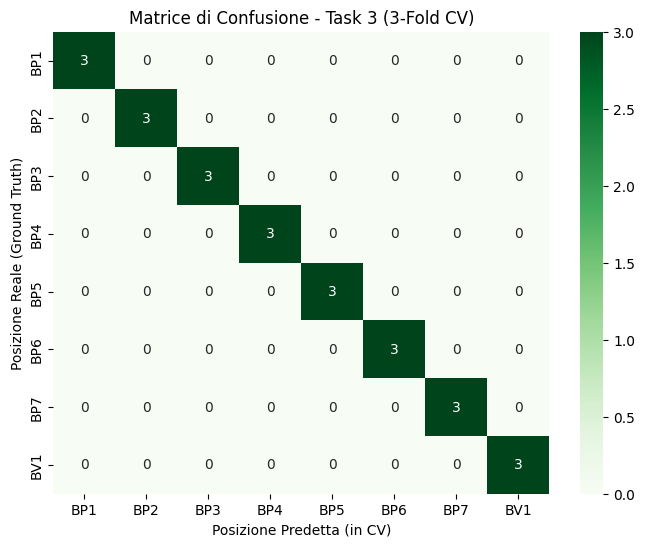


Addestramento finale del modello di localizzazione...

Top 5 Feature cruciali per localizzare le bolle:
1. P3_Start_Std (0.0472)
2. P3_Start_Mean (0.0375)
3. P2_Start_Mean (0.0373)
4. P5_Start_Mean (0.0354)
5. P5_Global_Min (0.0353)


In [ ]:
# =============================================================================
# TASK 3: TRAINING & VALIDAZIONE (CROSS-VALIDATION LOCALIZZAZIONE BOLLE)
# 1. Filtraggio: Isoliame solo i casi di "Bubble Anomaly" (Target_Task2 == 2).
# 2. Validazione Robusta (Stratified K-Fold) sulle 8 posizioni possibili.
#    (n_splits ridotto a 3 a causa dell'esiguo numero di campioni per classe)
# 3. Analisi analitica della distribuzione e delle feature più rilevanti.
# =============================================================================

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- 1. FILTRAGGIO DATI PER TASK 3 ---
df_bubbles = df[df['Target_Task2'] == 2].copy()
X_t3 = df_bubbles.drop(columns=drop_cols, errors='ignore')
y_t3 = df_bubbles['Target_Task3']

# Mappa etichette
bubble_labels = ['BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7', 'BV1']

print(f"Esempi totali di bolle: {len(df_bubbles)}")
print("\nDistribuzione per posizione:")
dist_t3 = y_t3.value_counts().sort_index()
for idx, count in dist_t3.items():
    label = bubble_labels[int(idx)-1] if int(idx) <= len(bubble_labels) else f"Pos_{idx}"
    print(f"- {label}: {count} campioni")

# --- 2. CONFIGURAZIONE CROSS-VALIDATION (Ridotta a 3-Fold) ---
# Usiamo 3 fold perché ogni classe ha solo 3 campioni.
n_folds = 3
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
clf_t3 = RandomForestClassifier(n_estimators=100, random_state=42)

print(f"\nAvvio Cross-Validation ({n_folds} Folds)...")

# --- 3. ESECUZIONE VALIDAZIONE ---
try:
    scores_t3 = cross_val_score(clf_t3, X_t3, y_t3, cv=cv, scoring='accuracy')

    print(f"\n--- RISULTATI ANALITICI TASK 3 ---")
    print(f"Accuratezza Media: {scores_t3.mean()*100:.2f}%")
    print(f"Deviazione Standard: (+/- {scores_t3.std()*100:.2f}%)")

    # Predizioni aggregate
    y_pred_cv_t3 = cross_val_predict(clf_t3, X_t3, y_t3, cv=cv)

    # --- 4. MATRICE DI CONFUSIONE ---
    cm3 = confusion_matrix(y_t3, y_pred_cv_t3)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm3, annot=True, fmt='d', cmap='Greens',
                xticklabels=bubble_labels,
                yticklabels=bubble_labels)
    plt.xlabel('Posizione Predetta (in CV)')
    plt.ylabel('Posizione Reale (Ground Truth)')
    plt.title(f'Matrice di Confusione - Task 3 ({n_folds}-Fold CV)')
    plt.show()

except ValueError as e:
    print(f"\n Errore nella Cross-Validation: {e}")
    print("Suggerimento: Il numero di campioni per classe è troppo basso per il numero di fold impostato.")

# --- 5. ADDESTRAMENTO FINALE ---
print("\nAddestramento finale del modello di localizzazione...")
clf_t3.fit(X_t3, y_t3)

# --- 6. FEATURE IMPORTANCE ---
importances = clf_t3.feature_importances_
indices = np.argsort(importances)[::-1]
print("\nTop 5 Feature cruciali per localizzare le bolle:")
for f in range(5):
    print(f"{f+1}. {X_t3.columns[indices[f]]} ({importances[indices[f]]:.4f})")

In [ ]:
# =============================================================================
# TASK 3: PREDIZIONE SUL TEST SET (ANALISI LOCALIZZAZIONE BOLLE)
# 1. Identificazione dei casi di bolle nel Test Set (predetti dal Task 2).
# 2. Localizzazione specifica tramite il modello addestrato.
# 3. Analisi della distribuzione delle predizioni per Spacecraft.
# =============================================================================

# Inizializziamo la colonna a 0
df_test['Task3_Pred'] = 0

# Applichiamo il modello solo dove Task2 ha predetto 2 (Bolle)
mask_bubbles = df_test['Task2_Pred'] == 2

if mask_bubbles.any():
    # Predizione
    preds_t3 = clf_t3.predict(X_test_final[mask_bubbles])
    df_test.loc[mask_bubbles, 'Task3_Pred'] = preds_t3

    # Calcolo probabilità (confidenza) per queste predizioni
    probs_t3 = np.max(clf_t3.predict_proba(X_test_final[mask_bubbles]), axis=1)

    # Mappa etichette per l'output analitico
    bubble_labels = ['BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7', 'BV1']

    print(f"--- ANALISI ANALITICA TEST SET: TASK 3 ---")
    print(f"Totale casi 'Bubble Anomaly' identificati: {mask_bubbles.sum()}")

    # Creazione di report
    report_t3 = pd.DataFrame({
        'Spacecraft': df_test.loc[mask_bubbles, 'Spacecraft'],
        'Posizione_Predetta': [bubble_labels[int(p)-1] for p in preds_t3],
        'Confidenza': probs_t3
    })

    print("\nDistribuzione delle posizioni trovate:")
    print(report_t3['Posizione_Predetta'].value_counts().to_string())

    print("\nSuddivisione per Spacecraft:")
    print(pd.crosstab(report_t3['Spacecraft'], report_t3['Posizione_Predetta']))

    print(f"\nConfidenza media del modello nel localizzare le bolle: {probs_t3.mean()*100:.2f}%")

else:
    print("--- ANALISI ANALITICA TEST SET: TASK 3 ---")
    print("Nessun caso di Bolle identificato dal Task 2. Il modello di localizzazione non è stato attivato.")

--- ANALISI ANALITICA TEST SET: TASK 3 ---
Totale casi 'Bubble Anomaly' identificati: 10

Distribuzione delle posizioni trovate:
Posizione_Predetta
BP2    2
BP1    2
BP7    2
BP6    1
BP4    1
BP3    1
BP5    1

Suddivisione per Spacecraft:
Posizione_Predetta  BP1  BP2  BP3  BP4  BP5  BP6  BP7
Spacecraft                                           
1                     1    1    0    1    0    1    1
4                     1    1    1    0    1    0    1

Confidenza media del modello nel localizzare le bolle: 83.10%


Esempi di guasti valvole nel training: 48

Distribuzione per valvola coinvolta:
- SV1: 12 campioni
- SV2: 12 campioni
- SV3: 12 campioni
- SV4: 12 campioni

Avvio Cross-Validation (5 Folds)...

--- RISULTATI ANALITICI TASK 4 ---
Accuratezza Media: 100.00%
Deviazione Standard: (+/- 0.00%)


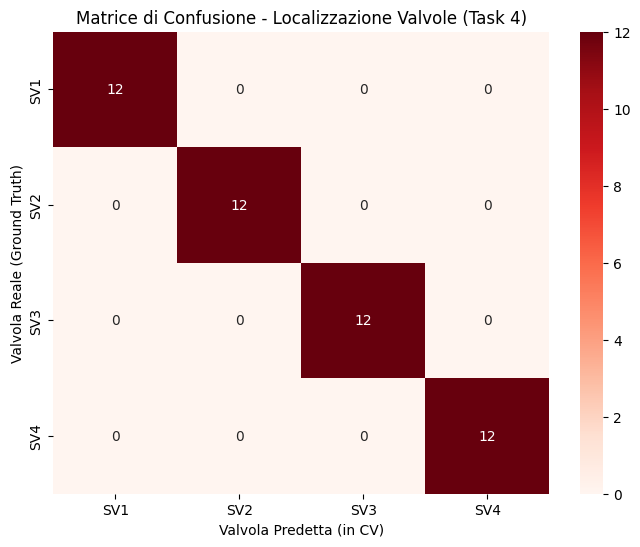


Addestramento finale del modello di localizzazione valvole...

Top 5 Feature cruciali per distinguere le valvole:
1. P6_Start_Std (0.0850)
2. P7_Start_Std (0.0796)
3. P3_Start_Std (0.0729)
4. P4_Start_Std (0.0586)
5. P4_Start_Slope (0.0519)


In [ ]:
# =============================================================================
# TASK 4: TRAINING & VALIDAZIONE (CROSS-VALIDATION LOCALIZZAZIONE VALVOLE)
# 1. Filtraggio: Isoliame solo i casi di "Valve Fault" (Target_Task2 == 3).
# 2. Validazione Robusta (Stratified 5-Fold) per identificare la valvola (SV1-SV4).
# 3. Analisi analitica delle performance e delle feature discriminanti.
# =============================================================================

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- 1. FILTRAGGIO DATI PER TASK 4 ---
# Lavoriamo solo sui casi dove è stato identificato un guasto alle elettrovalvole
df_valves = df[df['Target_Task2'] == 3].copy()

X_t4 = df_valves.drop(columns=drop_cols, errors='ignore')
y_t4 = df_valves['Target_Task4']

# Mappa etichette per SV1, SV2, SV3, SV4
valve_labels = [f'SV{i}' for i in range(1, 5)]

print(f"Esempi di guasti valvole nel training: {len(df_valves)}")
print("\nDistribuzione per valvola coinvolta:")
dist_t4 = y_t4.value_counts().sort_index()
for idx, count in dist_t4.items():
    label = valve_labels[int(idx)-1] if int(idx) <= len(valve_labels) else f"SV_{idx}"
    print(f"- {label}: {count} campioni")

# --- 2. CONFIGURAZIONE CROSS-VALIDATION (5-Fold Stratified) ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf_t4 = RandomForestClassifier(n_estimators=100, random_state=42)

print("\nAvvio Cross-Validation (5 Folds)...")

# --- 3. ESECUZIONE VALIDAZIONE ---
scores_t4 = cross_val_score(clf_t4, X_t4, y_t4, cv=cv, scoring='accuracy')

print(f"\n--- RISULTATI ANALITICI TASK 4 ---")
print(f"Accuratezza Media: {scores_t4.mean()*100:.2f}%")
print(f"Deviazione Standard: (+/- {scores_t4.std()*100:.2f}%)")

# Predizioni aggregate per la matrice
y_pred_cv_t4 = cross_val_predict(clf_t4, X_t4, y_t4, cv=cv)

# --- 4. VISUALIZZAZIONE MATRICE DI CONFUSIONE AGGREGATA ---
cm4 = confusion_matrix(y_t4, y_pred_cv_t4)
plt.figure(figsize=(8, 6))
sns.heatmap(cm4, annot=True, fmt='d', cmap='Reds',
            xticklabels=valve_labels,
            yticklabels=valve_labels)
plt.xlabel('Valvola Predetta (in CV)')
plt.ylabel('Valvola Reale (Ground Truth)')
plt.title('Matrice di Confusione - Localizzazione Valvole (Task 4)')
plt.show()

# --- 5. ADDESTRAMENTO FINALE (Full Retrain) ---
print("\nAddestramento finale del modello di localizzazione valvole...")
clf_t4.fit(X_t4, y_t4)

# --- 6. ANALISI FEATURE IMPORTANCE ---
importances = clf_t4.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nTop 5 Feature cruciali per distinguere le valvole:")
for f in range(5):
    print(f"{f+1}. {X_t4.columns[indices[f]]} ({importances[indices[f]]:.4f})")

In [ ]:
# =============================================================================
# TASK 4: PREDIZIONE SUL TEST SET (ANALISI LOCALIZZAZIONE VALVOLE)
# 1. Identificazione dei casi di guasto valvola nel Test Set (predetti dal Task 2).
# 2. Localizzazione specifica (SV1-SV4) tramite il modello addestrato.
# 3. Analisi della distribuzione e della confidenza per Spacecraft.
# =============================================================================

# Inizializziamo la colonna a 0
df_test['Task4_Pred'] = 0

# Applichiamo il modello solo dove Task2 ha predetto 3 (Valvole)
mask_valves = df_test['Task2_Pred'] == 3

if mask_valves.any():
    # Predizione della valvola specifica
    preds_t4 = clf_t4.predict(X_test_final[mask_valves])
    df_test.loc[mask_valves, 'Task4_Pred'] = preds_t4

    # Calcolo probabilità (confidenza) per queste predizioni
    probs_t4 = np.max(clf_t4.predict_proba(X_test_final[mask_valves]), axis=1)

    # Mappa etichette per l'output analitico
    valve_labels = ['SV1', 'SV2', 'SV3', 'SV4']

    print(f"--- ANALISI ANALITICA TEST SET: TASK 4 ---")
    print(f"Totale casi 'Valve Fault' identificati: {mask_valves.sum()}")

    # Creazione di report per l'analisi
    report_t4 = pd.DataFrame({
        'Spacecraft': df_test.loc[mask_valves, 'Spacecraft'],
        'Valvola_Predetta': [valve_labels[int(v)-1] for v in preds_t4],
        'Confidenza': probs_t4
    })

    print("\nDistribuzione delle valvole identificate:")
    print(report_t4['Valvola_Predetta'].value_counts().sort_index().to_string())

    print("\nSuddivisione guasti per Spacecraft:")
    summary_t4 = pd.crosstab(report_t4['Spacecraft'], report_t4['Valvola_Predetta'])
    print(summary_t4)

    print(f"\nConfidenza media nel localizzare la valvola guasta: {probs_t4.mean()*100:.2f}%")

    # Nota analitica sulla confidenza
    if probs_t4.min() < 0.7:
        print(f"⚠️ Nota: Alcuni casi hanno una confidenza bassa ({probs_t4.min()*100:.1f}%).")
        print("Potrebbero esserci sovrapposizioni nei segnali tra valvole vicine.")

else:
    print("--- ANALISI ANALITICA TEST SET: TASK 4 ---")
    print("Nessun caso di Guasto Valvola identificato dal Task 2.")

--- ANALISI ANALITICA TEST SET: TASK 4 ---
Totale casi 'Valve Fault' identificati: 9

Distribuzione delle valvole identificate:
Valvola_Predetta
SV2    5
SV3    2
SV4    2

Suddivisione guasti per Spacecraft:
Valvola_Predetta  SV2  SV3  SV4
Spacecraft                     
1                   2    1    1
4                   3    1    1

Confidenza media nel localizzare la valvola guasta: 71.00%
⚠️ Nota: Alcuni casi hanno una confidenza bassa (30.0%).
Potrebbero esserci sovrapposizioni nei segnali tra valvole vicine.


Esempi totali per la regressione: 153
Target medi (aperture): [  0.  25.  50.  75. 100.]%

Avvio Cross-Validation (5 Folds) con XGBoost...

--- RISULTATI ANALITICI TASK 5 (XGBoost) ---
MAE Medio (Errore medio di apertura): 0.74%
Deviazione Standard Errore: (+/- 0.67%)


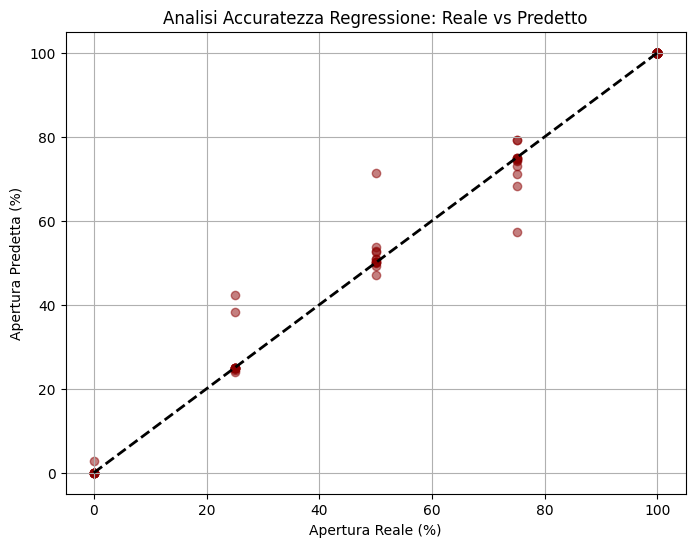


Addestramento finale del modello XGBoost su tutto il set...

Top 5 Feature che influenzano la stima dell'apertura:
1. P3_Start_Slope (0.5837)
2. P4_Start_Slope (0.1419)
3. P2_Start_Mean (0.1319)
4. P6_Start_Slope (0.0262)
5. P1_Start_Mean (0.0229)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# =============================================================================
# TASK 5: TRAINING & VALIDAZIONE (CROSS-VALIDATION XGBOOST REGRESSOR)
# 1. Preparazione: Uniamo i guasti alle valvole con i casi normali (apertura 100%).
# 2. Validazione Robusta (5-Fold K-Fold) per stimare il MAE (Errore Medio Assoluto).
# 3. Analisi visuale della precisione delle stime (True vs Predicted).
# =============================================================================

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- 1. PREPARAZIONE DATI PER TASK 5 ---
# Recuperiamo i guasti valvole (assicurandoci che il nome sia corretto)
df_valves = df[df['Target_Task2'] == 3].copy()

# Prepariamo i casi normali impostando l'apertura al 100%
df_normal_for_reg = df[df['Target_Task1'] == 0].copy()
df_normal_for_reg['Target_Task5'] = 100.0

# Uniamo i due set per coprire tutto il range di apertura (0, 25, 50, 75, 100)
df_reg_complete = pd.concat([df_valves, df_normal_for_reg])

X_reg = df_reg_complete.drop(columns=drop_cols, errors='ignore')
y_reg = df_reg_complete['Target_Task5']

print(f"Esempi totali per la regressione: {len(df_reg_complete)}")
print(f"Target medi (aperture): {np.sort(y_reg.unique())}%")

# --- 2. CONFIGURAZIONE CROSS-VALIDATION (5-Fold K-Fold) ---
# Per la regressione usiamo KFold semplice
cv_reg = KFold(n_splits=5, shuffle=True, random_state=42)

reg_t5 = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    objective='reg:squarederror',
    random_state=42
)

print("\nAvvio Cross-Validation (5 Folds) con XGBoost...")

# --- 3. ESECUZIONE VALIDAZIONE ---
# Calcoliamo il MAE (Mean Absolute Error) per ogni fold
from sklearn.model_selection import cross_validate
cv_results = cross_validate(reg_t5, X_reg, y_reg, cv=cv_reg,
                            scoring='neg_mean_absolute_error',
                            return_train_score=False)

mae_scores = -cv_results['test_score']

print(f"\n--- RISULTATI ANALITICI TASK 5 (XGBoost) ---")
print(f"MAE Medio (Errore medio di apertura): {mae_scores.mean():.2f}%")
print(f"Deviazione Standard Errore: (+/- {mae_scores.std():.2f}%)")

# Generiamo le predizioni in Cross-Validation per l'analisi visuale
y_pred_cv_reg = cross_val_predict(reg_t5, X_reg, y_reg, cv=cv_reg)

# --- 4. ANALISI VISUALE: REALTÀ VS PREDIZIONE ---
plt.figure(figsize=(8, 6))
plt.scatter(y_reg, y_pred_cv_reg, alpha=0.5, color='darkred')
plt.plot([y_reg.min(), y_reg.max()], [y_reg.min(), y_reg.max()], 'k--', lw=2)
plt.xlabel('Apertura Reale (%)')
plt.ylabel('Apertura Predetta (%)')
plt.title('Analisi Accuratezza Regressione: Reale vs Predetto')
plt.grid(True)
plt.show()

# --- 5. ADDESTRAMENTO FINALE (Full Retrain) ---
print("\nAddestramento finale del modello XGBoost su tutto il set...")
reg_t5.fit(X_reg, y_reg)

# --- 6. FEATURE IMPORTANCE ---
importances_reg = reg_t5.feature_importances_
indices_reg = np.argsort(importances_reg)[::-1]
print("\nTop 5 Feature che influenzano la stima dell'apertura:")
for f in range(5):
    print(f"{f+1}. {X_reg.columns[indices_reg[f]]} ({importances_reg[indices_reg[f]]:.4f})")

reg_t5.fit(X_reg, y_reg)

In [ ]:
# =============================================================================
# TASK 5: PREDIZIONE SUL TEST SET (ANALISI STIMA APERTURA)
# 1. Identificazione dei casi di guasto valvola nel Test Set.
# 2. Stima della percentuale di apertura (Opening Ratio) tramite XGBoost.
# 3. Analisi statistica delle aperture stimate per Spacecraft.
# =============================================================================

# Inizializziamo la colonna a 100.0 (default per i casi normali o bolle)
df_test['Task5_Pred'] = 100.0

# Applichiamo il modello solo dove Task2 ha predetto 3 (Valvole)
mask_valves = df_test['Task2_Pred'] == 3

if mask_valves.any():
    # Esecuzione della regressione
    preds_t5 = reg_t5.predict(X_test_final[mask_valves])
    df_test.loc[mask_valves, 'Task5_Pred'] = preds_t5

    print(f"--- ANALISI ANALITICA TEST SET: TASK 5 (XGBOOST) ---")
    print(f"Totale stime di apertura effettuate: {mask_valves.sum()}")

    # Analisi statistica descrittiva
    print(f"\nStatistiche delle aperture predette (Opening Ratio):")
    print(f"- Media:   {preds_t5.mean():.2f}%")
    print(f"- Minima:  {preds_t5.min():.2f}%")
    print(f"- Massima: {preds_t5.max():.2f}%")

    # Suddivisione per Spacecraft
    # Questo aiuta a capire se lo Spacecraft 4 ha stime coerenti con lo Spacecraft 1
    report_t5 = pd.DataFrame({
        'Spacecraft': df_test.loc[mask_valves, 'Spacecraft'],
        'Apertura': preds_t5
    })

    print("\nApertura media stimata per Spacecraft:")
    print(report_t5.groupby('Spacecraft')['Apertura'].mean().round(2).to_string())

    # Alert per valori fuori range teorico (XGBoost può generare valori <0 o >100)
    if (preds_t5 < 0).any() or (preds_t5 > 100).any():
        print("\n⚠️ Nota: Alcune predizioni superano i limiti teorici (0-100%).")
        print("Questo è tipico dei modelli di regressione e può essere corretto con un clipping.")

else:
    print("--- ANALISI ANALITICA TEST SET: TASK 5 ---")
    print("Nessun caso di Guasto Valvola identificato. Tutte le aperture rimangono al 100.0%.")

--- ANALISI ANALITICA TEST SET: TASK 5 (XGBOOST) ---
Totale stime di apertura effettuate: 9

Statistiche delle aperture predette (Opening Ratio):
- Media:   61.93%
- Minima:  28.40%
- Massima: 95.69%

Apertura media stimata per Spacecraft:
Spacecraft
1    58.139999
4    64.959999


In [ ]:
# =============================================================================
# GENERAZIONE FILE DI SUBMISSION
# 1. Formattazione della descrizione testuale.
# 2. Creazione e salvataggio del CSV finale.
# =============================================================================

import pandas as pd

# Logica di formattazione "Test condition"
def get_test_condition_format(row):
    t1, t2, t3, t4, t5 = row['Task1_Pred'], row['Task2_Pred'], int(row['Task3_Pred']), int(row['Task4_Pred']), row['Task5_Pred']

    if t1 == 0:
        return "Normal"
    elif t2 == 1:
        return "Unknown anomaly"
    elif t2 == 2:
        pos_label = f"BP{t3}" if t3 <= 7 else "BV1"
        return f"Bubble anomaly ({pos_label})"
    elif t2 == 3:
        return f"Valve fault (SV{t4}, {round(t5, 1)}%)"
    return "N/A"

df_test['Test condition'] = df_test.apply(get_test_condition_format, axis=1)

# Creazione del DataFrame di Submission Finale
submission_finale = pd.DataFrame({
    'Id': df_test['Case'],
    'Task 1': df_test['Task1_Pred'].astype(int),
    'Task 2': df_test['Task2_Pred'].astype(int),
    'Task 3': df_test['Task3_Pred'].astype(int),
    'Task 4': df_test['Task4_Pred'].astype(int),
    'Task 5': df_test['Task5_Pred'].round(2),
    'Test condition': df_test['Test condition']
})

# Salvataggio su Google Drive
OUTPUT_PATH = "/content/drive/MyDrive/submission_finale_PHM.csv"
submission_finale.to_csv(OUTPUT_PATH, index=False)

print(f"🚀 Submission generata con successo in: {OUTPUT_PATH}")
display(submission_finale[['Id', 'Test condition']].head(15))

🚀 Submission generata con successo in: /content/drive/MyDrive/Manutenzione/submission_finale_PHM_v1.csv


,Id,Test condition
0,178,Bubble anomaly (BP2)
1,179,"Valve fault (SV2, 29.1%)"
2,180,Normal
3,181,"Valve fault (SV4, 76.4%)"
4,182,Normal
5,183,Normal
6,184,Unknown anomaly
7,185,Normal
8,186,Bubble anomaly (BP6)
9,187,Normal
